In [1]:
# Prepare packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import idx2numpy
import os

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [2]:
# Define the device to be used for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Prepare data
# Load the training set
X_train = idx2numpy.convert_from_file('../datasets/MNIST/raw/train-images-idx3-ubyte')
y_train = idx2numpy.convert_from_file('../datasets/MNIST/raw/train-labels-idx1-ubyte')

# Load the test set
X_test = idx2numpy.convert_from_file('../datasets/MNIST/raw/t10k-images-idx3-ubyte')
y_test = idx2numpy.convert_from_file('../datasets/MNIST/raw/t10k-labels-idx1-ubyte')

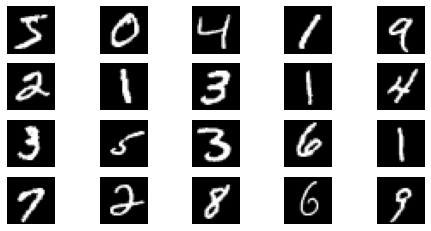

In [4]:
# Display 20 images from train_x
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_train[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

In [7]:
# Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.logsoftmax(self.fc3(x))
        return x
    
        
# Define my dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define my loss function
class JointLoss(nn.Module):
    def __init__(self):
        super(JointLoss, self).__init__()

    def forward(self, inputs, labels):
        labels_oh = F.one_hot(labels, num_classes=10).float()
        loss = F.mse_loss(inputs, labels_oh)
        return loss

In [52]:
# Set up the data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../datasets', train=True, transform=transforms.Compose([
            transforms.ToTensor()
        ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../datasets', train=False, transform=transforms.Compose([
            transforms.ToTensor()
        ])),
    batch_size=1000, shuffle=True)

# Set up model, loss function, and optimizer
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
# criterion = JointLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/10], Step [100/938], Loss: 0.2603
Epoch [1/10], Step [200/938], Loss: 0.3321
Epoch [1/10], Step [300/938], Loss: 0.4613
Epoch [1/10], Step [400/938], Loss: 0.1808
Epoch [1/10], Step [500/938], Loss: 0.3329
Epoch [1/10], Step [600/938], Loss: 0.0683
Epoch [1/10], Step [700/938], Loss: 0.3692
Epoch [1/10], Step [800/938], Loss: 0.1802
Epoch [1/10], Step [900/938], Loss: 0.1199
Epoch [2/10], Step [100/938], Loss: 0.2955
Epoch [2/10], Step [200/938], Loss: 0.0730
Epoch [2/10], Step [300/938], Loss: 0.0889
Epoch [2/10], Step [400/938], Loss: 0.1889
Epoch [2/10], Step [500/938], Loss: 0.0757
Epoch [2/10], Step [600/938], Loss: 0.1056
Epoch [2/10], Step [700/938], Loss: 0.1093
Epoch [2/10], Step [800/938], Loss: 0.0785
Epoch [2/10], Step [900/938], Loss: 0.1472
Epoch [3/10], Step [100/938], Loss: 0.0339
Epoch [3/10], Step [200/938], Loss: 0.2025
Epoch [3/10], Step [300/938], Loss: 0.0447
Epoch [3/10], Step [400/938], Loss: 0.0616
Epoch [3/10], Step [500/938], Loss: 0.0573
Epoch [3/10

In [53]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                   [-1, 64]          16,448
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
        LogSoftmax-6                   [-1, 10]               0
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.83
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [54]:
# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
#         print(images, labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

Accuracy: 97.87%


## Test on different types of noise

In [55]:
accuracy = []

correct = 0
total = 0
X_test1 = torch.from_numpy(np.reshape(X_test.copy(), (10000, 1, 28, 28))).float()
X_t1 = torch.utils.data.DataLoader(MyDataset(X_test1 / 255, y_test), batch_size=1000, shuffle=True)
with torch.no_grad():
    for data in X_t1:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
    #     print(type(labels))
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

Accuracy: 97.87%


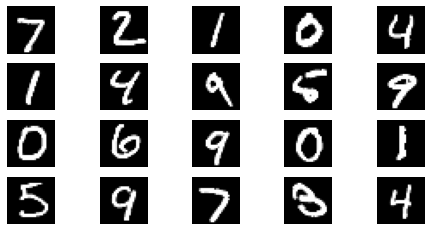

Accuracy: 26.19%


In [56]:
transform=transforms.Compose([
            transforms.ToTensor()
        ])
X_test2 = np.load('../datasets/mnist_c/brightness/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/brightness/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

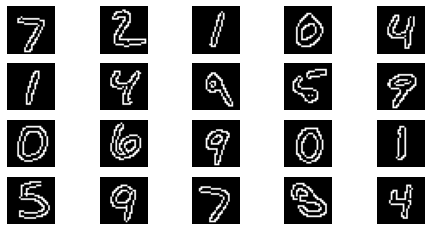

Accuracy: 68.61%


In [57]:
X_test2 = np.load('../datasets/mnist_c/canny_edges/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/canny_edges/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

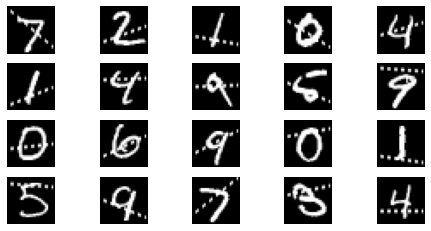

Accuracy: 91.60%


In [58]:
X_test2 = np.load('../datasets/mnist_c/dotted_line/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/dotted_line/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

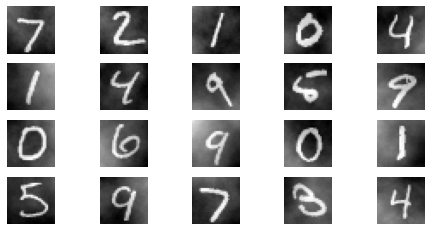

Accuracy: 17.04%


In [59]:
X_test2 = np.load('../datasets/mnist_c/fog/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/fog/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

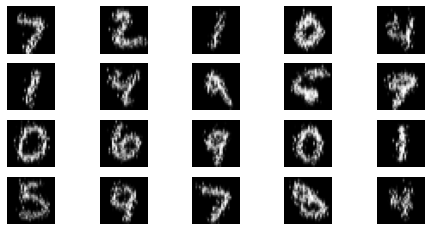

Accuracy: 94.84%


In [60]:
X_test2 = np.load('../datasets/mnist_c/glass_blur/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/glass_blur/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

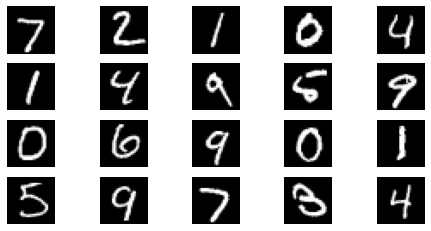

Accuracy: 97.87%


In [61]:
X_test2 = np.load('../datasets/mnist_c/identity/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/identity/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

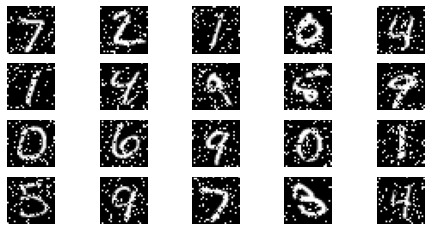

Accuracy: 82.09%


In [62]:
X_test2 = np.load('../datasets/mnist_c/impulse_noise/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/impulse_noise/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

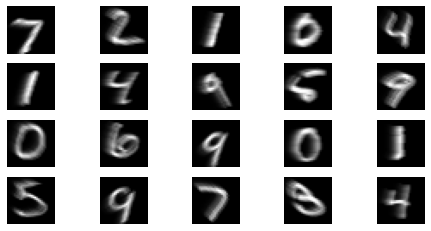

Accuracy: 88.86%


In [63]:
X_test2 = np.load('../datasets/mnist_c/motion_blur/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/motion_blur/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

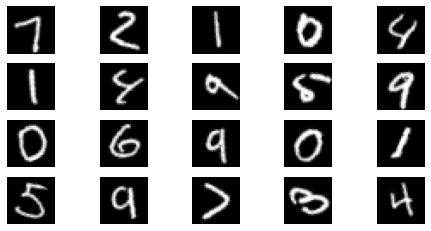

Accuracy: 85.20%


In [64]:
X_test2 = np.load('../datasets/mnist_c/rotate/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/rotate/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

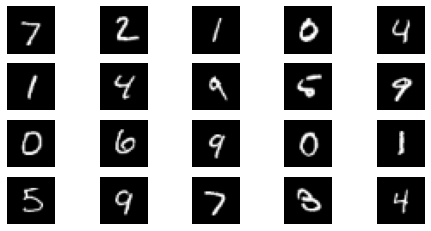

Accuracy: 63.92%


In [65]:
X_test2 = np.load('../datasets/mnist_c/scale/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/scale/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

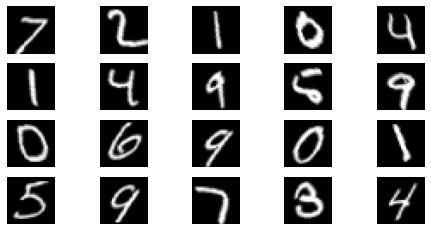

Accuracy: 92.84%


In [66]:
X_test2 = np.load('../datasets/mnist_c/shear/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/shear/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

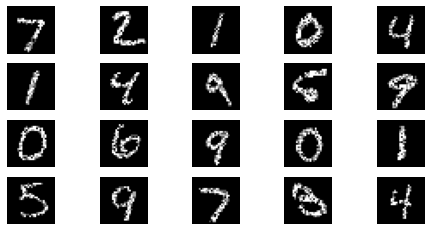

Accuracy: 96.95%


In [67]:
X_test2 = np.load('../datasets/mnist_c/shot_noise/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/shot_noise/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

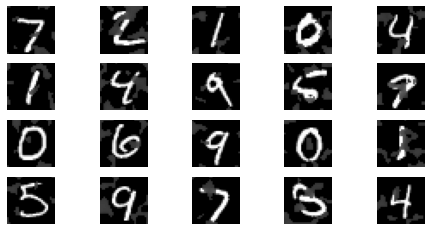

Accuracy: 93.53%


In [68]:
X_test2 = np.load('../datasets/mnist_c/spatter/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/spatter/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

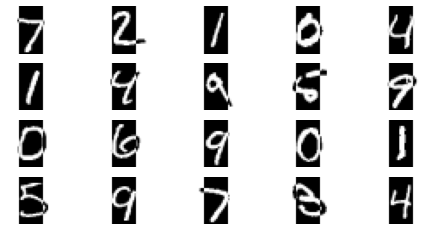

Accuracy: 17.03%


In [69]:
X_test2 = np.load('../datasets/mnist_c/stripe/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/stripe/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

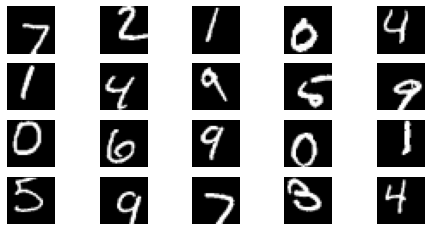

Accuracy: 33.03%


In [70]:
X_test2 = np.load('../datasets/mnist_c/translate/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/translate/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

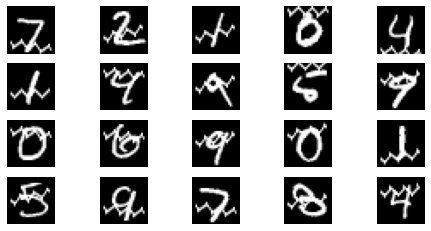

Accuracy: 68.38%


In [71]:
X_test2 = np.load('../datasets/mnist_c/zigzag/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/zigzag/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

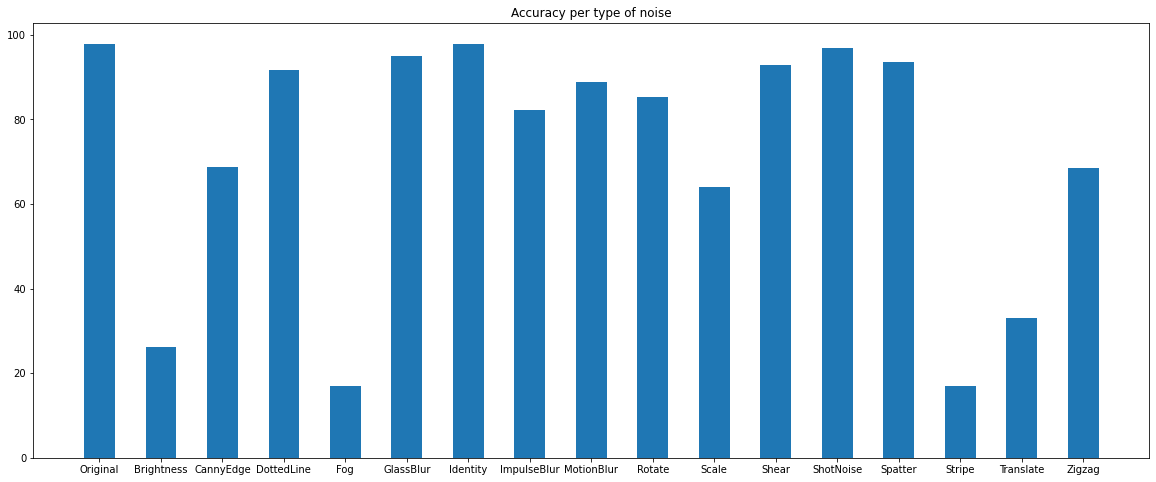

In [72]:
fig = plt.figure(figsize=(20, 8))
plt.bar(np.arange(len(accuracy)), accuracy, width=0.5)
plt.xticks(range(len(accuracy)), ['Original', 'Brightness', 'CannyEdge', 'DottedLine', 'Fog', 
                                  'GlassBlur', 'Identity', 'ImpulseBlur', 'MotionBlur', 'Rotate',
                                 'Scale', 'Shear', 'ShotNoise', 'Spatter', 'Stripe', 'Translate',
                                 'Zigzag'])
plt.title('Accuracy per type of noise')
plt.show()